In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from deepq import DeepQPLayer,RandomPlayer,QPlayer,Board
from IPython.display import clear_output
import time

2024-02-26 08:13:30.811206: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 08:13:30.811252: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 08:13:30.811267: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

In [4]:
def replay(all_boards,sleep_time:int=1):
    for board in all_boards:
        visualize(board)
        time.sleep(sleep_time)
        clear_output(wait=True)

In [5]:
def get_next_board_state(board,action,player_symbol):
    try:
        _board = board.copy()
        col = _board[:,action]
        idx = int(np.where(col == 0)[0][-1])
        col[idx] = player_symbol
        return _board
    except:
        return None
def get_possible_moves(board):
    return [i for i,j in enumerate(board[0]) if j == 0]

In [6]:
def test_simulate_game(player:DeepQPLayer,num_moves=4):
    player.reset()
    brd = np.zeros(shape=(player.num_cols,player.num_rows))
    for i in range(num_moves):
        p1_act = player.choose_action(get_possible_moves(brd),brd)
        brd = get_next_board_state(brd,p1_act,player.player_symbol)
        brd = get_next_board_state(brd,np.random.choice(get_possible_moves(brd)),player.player_symbol * -1)

        player.give_reward(0,s_prime=brd)
        

# test_simulate_game(p)
    

In [7]:
def custom_cooling(eps,itr):
    if itr < 25000 :
        return eps
    elif itr < 50000 :
        return eps / 2.0
    elif itr < 75000 :
        return eps / 4.0
    else:
        return eps / 8.0
    
q1 = DeepQPLayer(player_symbol=1,name='q_1_cooling_deep')


q1.loadPolicy('q_network_q_1_cooling_deep_v2')
q2 = QPlayer(player_symbol=-1,name='q_2_cooling_deep')

b = Board(q1,q2,num_rows=4,num_cols=4,cooling_func=custom_cooling)

q_1_cooling_deep Loaded Q and Q Prime networks from file q_network_q_1_cooling_deep_v2


In [8]:
winners = []

# r1 = RandomPlayer(player_symbol=-1)
q2.loadPolicy('policy_q_2_cooling')
b2 = Board(q1,q2,num_rows=4,num_cols=4)
for i in range(1000):
    q1.epsilon = 0.0
    q2.epsilon = 0.0
    winners.append(b2.play_agents(verbose=False))
    b2.reset()
    q1.reset()
    q2.reset()

winners = [i if i is not None else 0 for i in winners]
print(np.unique(winners,return_counts=True))



(array([-1,  0,  1]), array([163, 281, 556]))


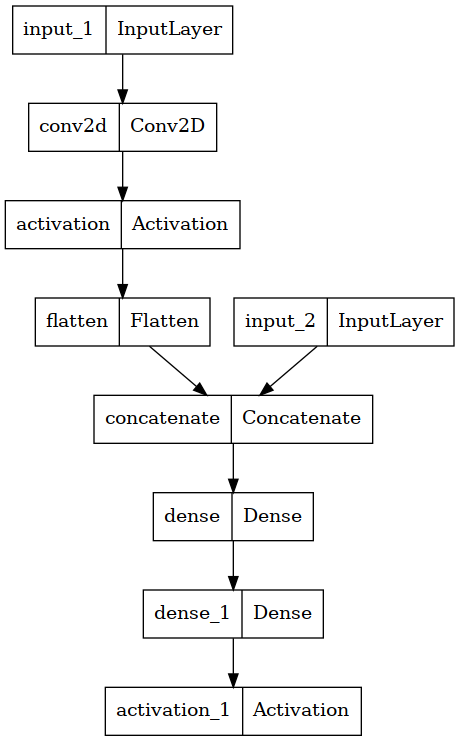

In [16]:
tf.keras.utils.plot_model(q1.q_network)

[ 0.03444625 -0.10090428 -0.06469548 -0.13294283]


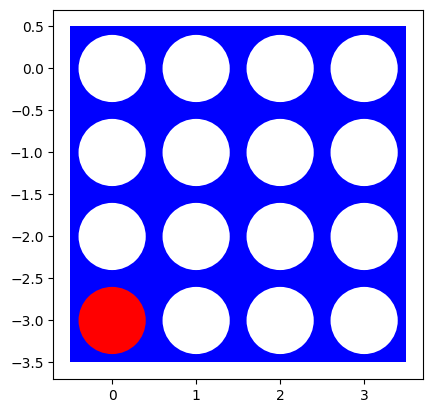


Never Seen State


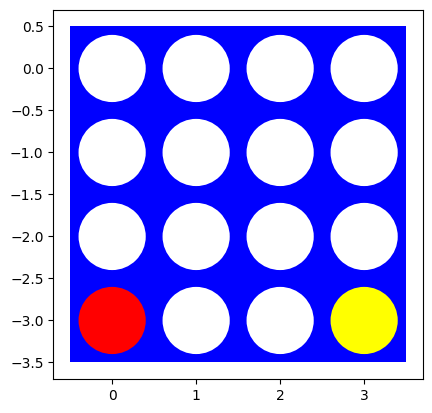


[ 0.03444625 -0.10090428 -0.06469548 -0.13294283]


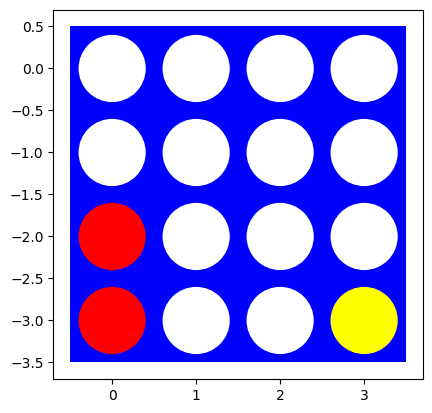


Never Seen State


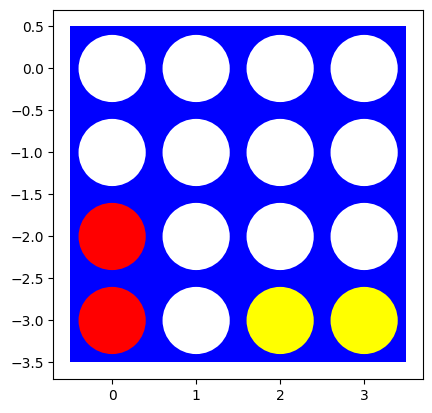


[0.3508552  0.2267019  0.26099217 0.19566822]


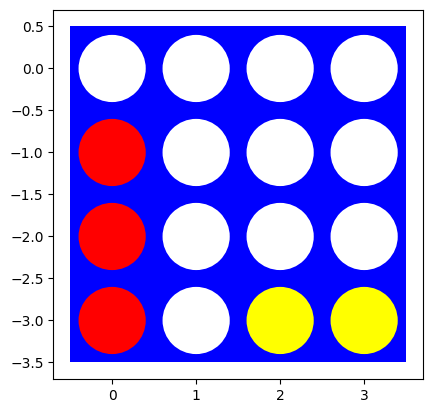


Never Seen State


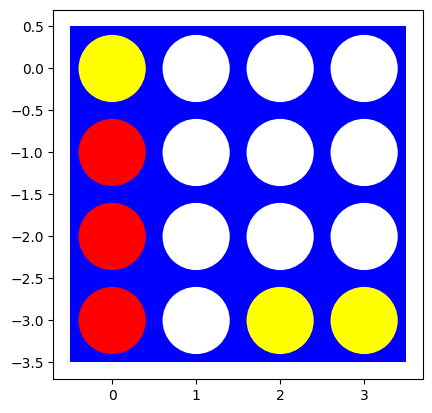


[ 0.13985835  0.00507234  0.0415114  -0.02740637]


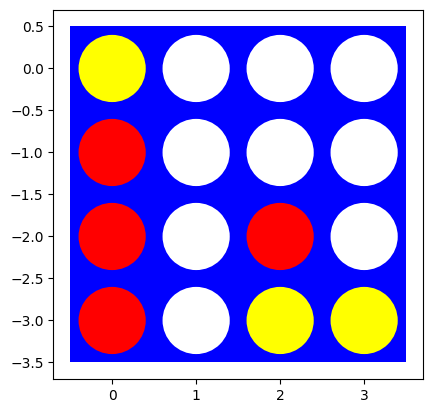


Never Seen State


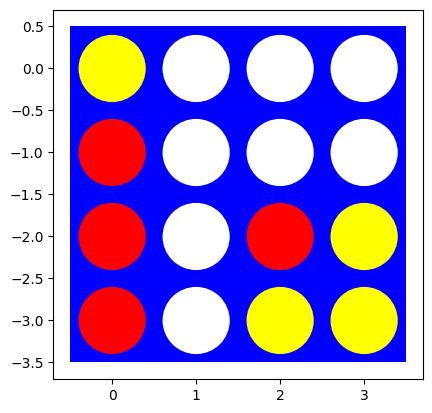


[ 0.0758922  -0.05959962 -0.0232033  -0.09189598]


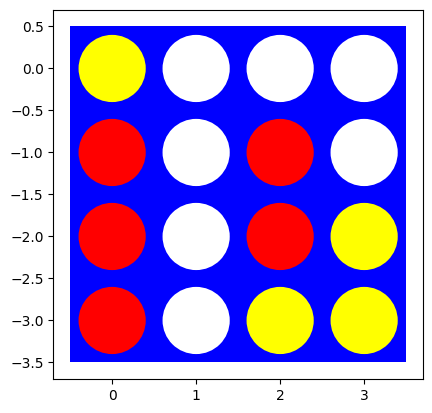


Never Seen State


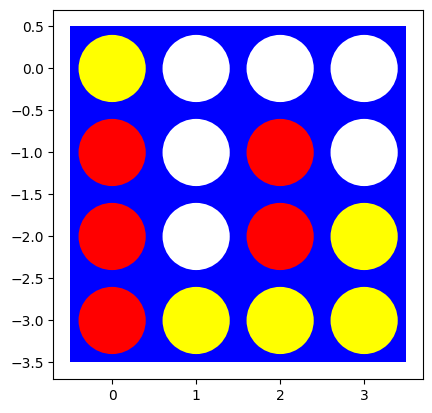


[ 0.06699772 -0.06850301 -0.0321365  -0.10075305]


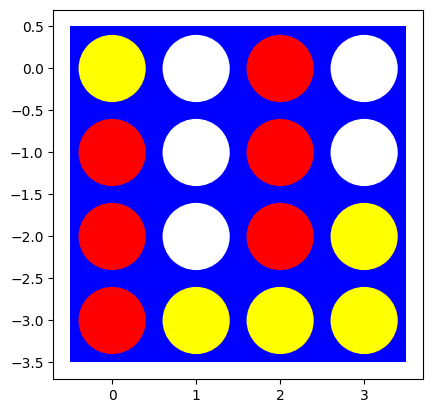


Never Seen State


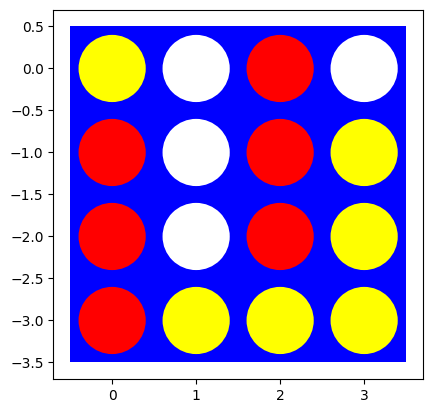


[0.3981717  0.27823272 0.31152043 0.24799933]


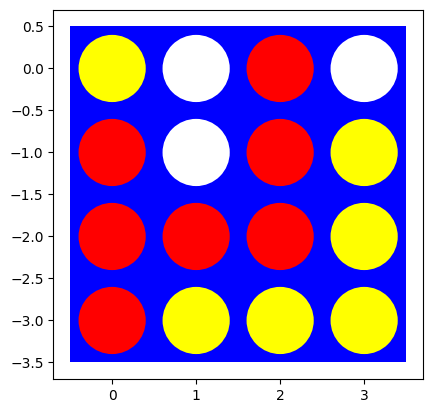


Never Seen State


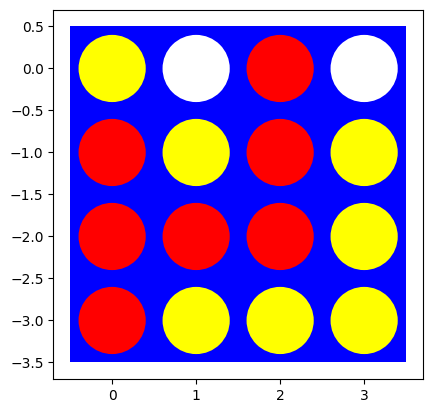


[0.9977606  0.99706316 0.9972695  0.99686635]


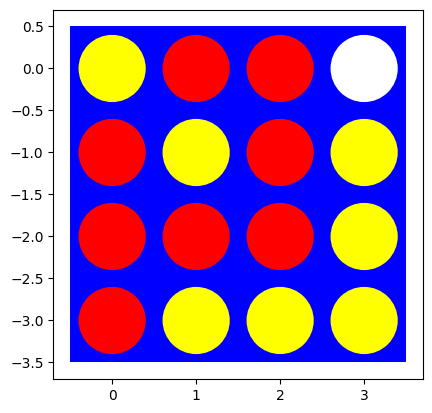


Never Seen State


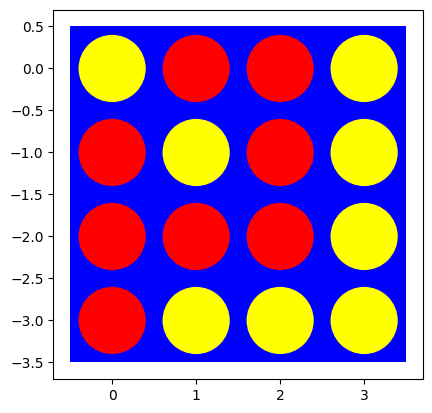

In [15]:
q1.reset()
q2.reset()
q1.epsilon = 0.0
# q2.epsilon = 0.5
b2.reset()
boards = b2.play_agents(return_boards=False,verbose=2)

# replay(boards)

In [ ]:
tmp = tf.keras.models.load_model('q_network_q_1_cooling_deep')


In [ ]:
tmp([np.zeros(shape=(1,4,4,1)),np.array([1]).reshape(1,1)])

ValueError: Exception encountered when calling layer 'model' (type Functional).

Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 52, but received input with shape (1, 49)

Call arguments received by layer 'model' (type Functional):
  • inputs=['tf.Tensor(shape=(1, 4, 4, 1), dtype=float64)', 'tf.Tensor(shape=(1, 1), dtype=int64)']
  • training=None
  • mask=None